# ESTRATÉGIAS DE TREINO

## Treino do zeo -- from scratch

In [19]:
# Implementação e treinamento da rede
import torch
from torch import nn, optim

# Carregamento de Dados e Modelos
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torchvision import transforms

# Plots e análises
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import time, os

%matplotlib inline

# Como otimizar hiperparametros: GridSearch
# https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
# Configurando hiperparâmetros.
args = {
    'epoch_num': 5,      # Número de épocas.
    'lr': 1e-3,           # Taxa de aprendizado.
    'weight_decay': 5e-4, # Penalidade L2 (Regularização).
    'batch_size': 50,     # Tamanho do batch.
}

# Definindo dispositivo de hardware
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


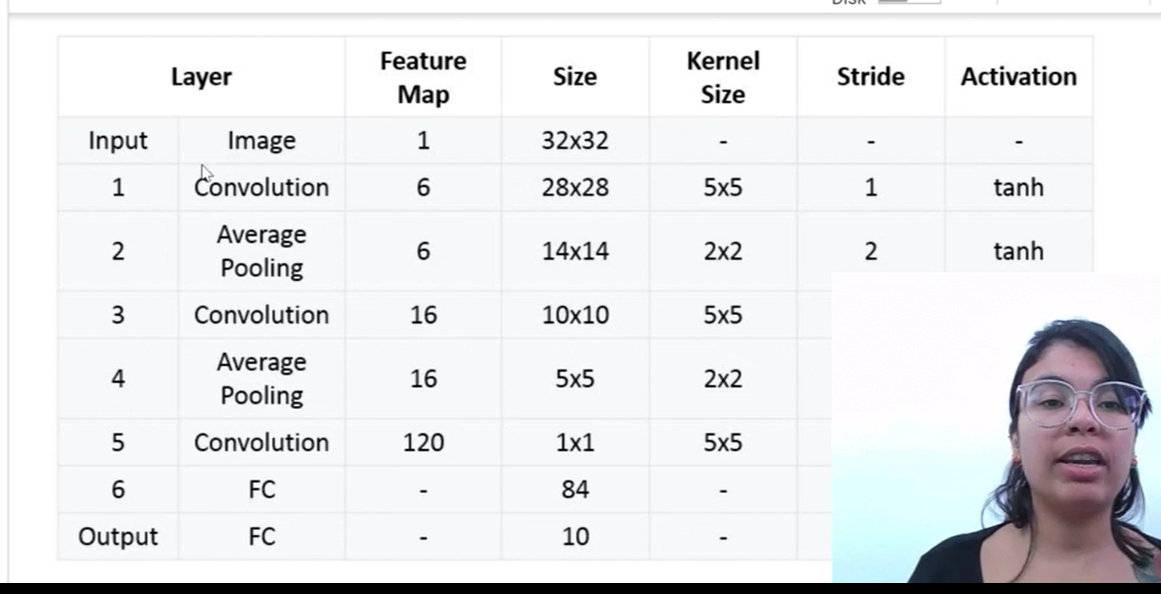

A unica diferença, é que a imagem de entrada vai ter 3 canais.

In [20]:


net = nn.Sequential(
  # in_channels: 3 - imagem colorida
  # out_channels: 6 filtros de saida, como especificado plela tabela
  # kernel_size : 5 (5x5)
  # a imagem original perde 4 pixes de resolução, vai de 32 para 28. Podemos calcular que o padding usado foi 0.
  # entrada imagem (batch, 3, 32, 32) saida (batch, 6, 28, 28)
  nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
  nn.BatchNorm2d(6), #normalização de batch recebe 6 canais.
  nn.Tanh(), # ativação especifica da LeNet

  # entrada imagem (batch, 3, 28, 28) saida (batch, 6, 14, 14)
  # o avarage pooling vai reduzir a imagem (mapa de caracteristicas) pela metade, de 28x28 para 14x14
  nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
  
  # 16 feature maps de saida
  # entrada imagem (batch, 6, 14, 14) saida (batch, 16, 10, 10)
  nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
  nn.BatchNorm2d(16),
  nn.Tanh(),

  # entrada (batch, 16, 10, 10) saida (batch, 16, 5, 5)
  nn.AvgPool2d(kernel_size=2, stride=2, padding=0),

  # entrada imagem (batch, 16, 5, 5) saida (batch, 120, 1, 1)
  nn.Conv2d(16, 120, kernel_size=5),
  nn.BatchNorm2d(120), #normalização de batch recebe 5 canais.
  nn.Tanh(), # ativação especifica da LeNet

  # preparação para a camada linear
  nn.Flatten(), # preparação para a camada totalmente conectada, que precisa de entradas lineares.

  # camada de flaten para linearizar o resultado 
  # entrada = (batch, N=120*1*1) saida = (batchm 84)
  # camada totalmente conectada com 84 neuronios
  nn.Linear(120, 84),
  nn.Tanh(), 

  # entrada (batch, 84), saida (b, 10)
  nn.Linear(84, 10),
)

print(net)
net = net.to(args['device'])

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Tanh()
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Tanh()
  (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (8): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Tanh()
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=120, out_features=84, bias=True)
  (13): Tanh()
  (14): Linear(in_features=84, out_features=10, bias=True)
)


In [31]:
train_set = datasets.CIFAR10('.',
                             train=True,
                             transform=transforms.ToTensor(),
                             download=True)

test_set = datasets.CIFAR10(',',
                            train=False,
                            transform=transforms.ToTensor(),
                            download=True)

Files already downloaded and verified
Files already downloaded and verified


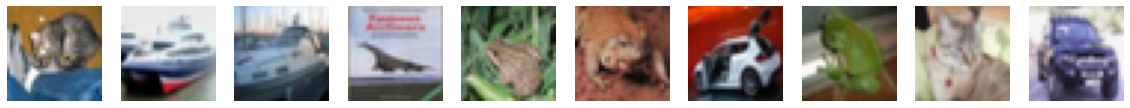

In [22]:
fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
  data, label = test_set[i]
  axs[i].imshow(data.permute(1, 2, 0))
  axs[i].axis('off')

In [32]:
train_load = DataLoader(train_set,
                        batch_size=args['batch_size'],
                        shuffle=True)
test_load = DataLoader(test_set,
                        batch_size=args['batch_size'],
                        shuffle=True)


In [24]:
from torch import optim

criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = optim.Adam(net.parameters(), 
                       lr=args['lr'], 
                       weight_decay=args['weight_decay'])

# Fluxo de Treinamento

Relembrando o passo a passo do fluxo de treinamento:

* Iterar nas épocas
* Iterar nos batches
* Cast dos dados no dispositivo de hardware
* Forward na rede e cálculo da loss
* Zerar o gradiente do otimizador
* Cálculo do gradiente e atualização dos pesos




In [25]:
# Epocas quantas vezes vou ver todo o conjunto dos dados?
# Batch: a cada epoca, eu vou ver de quantos em quantos dados?
# aqui, o batch será de 50, então serão vistos de 50 em 50 dados

# Durante cada epoca serão vistos 60k dados -- tamanho do dataset
# a cada iteração serão vistos 50 dados
# Durante cada epoca serão feitas 60k/50 = 1.2k iterações por epoca


for epoch in range(args['epoch_num']):
  epoch_loss = []
  for batch in train_load:

    # cast no hardware
    dado, rotulo = batch
    dado = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])

    # fazer o forward na red
    # print(dado.size())
    ypred = net(dado)

    loss = criterion(ypred, rotulo)
    # print(loss.item())
    epoch_loss.append(loss.detach().item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  epoch_loss = np.array(epoch_loss)
  print("Avg Epoch Loss: " + str(epoch_loss.mean()))


KeyboardInterrupt: ignored

In [26]:
def train(train_loader, net, epoch):

  # Training mode
  net.train()

  start = time.time()

  epoch_loss = []
  pred_list, rotulo_list = [], []
  for batch in train_loader:
    dado, rotulo = batch

    # Cast para a GPU
    dado = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])

    # Forward
    ypred = net(data)
    loss = criterion(ypred, rotulo)
    epoch_loss.append(loss.cpu().numpy())

    _, pred = torch.max(ypred, axis=1)
    pred_list.append(pred.cpu().numpy())
    rotulo_list.append(rotulo.cpu().numpy())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  epoch_loss = np.asarray(epoch_loss)
  pred_list = np.asarray(pred_list).revel()
  rotulo_list = np.asarrya(rotulo_list).revel()

  acc = accuracy_score(pred_list, rotulo_list)
  end = time.time()

  print('#################### Train ####################')
  print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f, Time: %.2f' % (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100, end-start))

  return epoch_loss.mean()


def validate(test_loader, net, epoch):

  # Evaluation mode
  net.eval()
  
  start = time.time()
  
  epoch_loss  = []
  pred_list, rotulo_list = [], []
  with torch.no_grad(): 
    for batch in test_loader:

      dado, rotulo = batch

      # Cast do dado na GPU
      dado = dado.to(args['device'])
      rotulo = rotulo.to(args['device'])

      # Forward
      ypred = net(dado)
      loss = criterion(ypred, rotulo)
      epoch_loss.append(loss.cpu().data)

      _, pred = torch.max(ypred, axis=1)
      pred_list.append(pred.cpu().numpy())
      rotulo_list.append(rotulo.cpu().numpy())

  epoch_loss = np.asarray(epoch_loss)
  pred_list  = np.asarray(pred_list).ravel()
  rotulo_list  = np.asarray(rotulo_list).ravel()

  acc = accuracy_score(pred_list, rotulo_list)
  
  end = time.time()
  print('********** Validate **********')
  print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f, Time: %.2f\n' % (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100, end-start))
  
  return epoch_loss.mean()








In [34]:
train_losses, test_losses = [], []

for epoch in range(args['epoch_num']):
  
  # Train
  train_losses.append(train(train_load, net, epoch))
  
  # Validate
  test_losses.append(validate(test_load, net, epoch))

RuntimeError: ignored